## Σκοπός και Μεθοδολογία του Script

## Πηγή Δεδομένων

Τα δεδομένα προέρχονται από δύο διαφορετικά κέντρα:

- **Ηράκλειο**: αρχείο `CLINICAL_NEW_MINE (1).xlsx`  
- **Πάτρα**: αρχείο `Patients_Clinical_Data_face_110624_IB.xlsx`

Το script ενοποιεί αυτά τα δύο σύνολα σε ένα ενιαίο `dataframe` για συνολική ανάλυση.

## Κύριος Στόχος

Ο πρωταρχικός στόχος είναι η **κατανόηση και οπτικοποίηση της δημογραφικής κατανομής των ασθενών** (με βάση το φύλο `F` / `M`) ως προς διάφορες βασικές **κλινικές κατηγορίες**, όπως:

- Η σταδιοποίηση της νόσου (Hoehn & Yahr)  
- Η παρουσία κινητικών διακυμάνσεων (Fluctuations)  
- Η παρουσία δυσκινησίας (Dyskinesia)  
- Η ποιότητα και το ποσοστό απόκρισης στη Levodopa  

## Αυτοματοποιημένη Διαδικασία

Το script εκτελεί αυτοματοποιημένα τα εξής βήματα:

1. **Καθαρισμός και προετοιμασία** των δεδομένων  
2. **Δημιουργία νέων κατηγορικών μεταβλητών** (π.χ. κατηγοριοποίηση του ποσοστού απόκρισης στη Levodopa)  
3. **Παραγωγή συνοπτικών πινάκων** με κατανομή φύλου για κάθε κατηγορία  
4. **Δημιουργία και αποθήκευση γραφημάτων** (bar plots) υψηλής αισθητικής για κάθε μεταβλητή  

## Τελικά Παραδοτέα

- Φάκελος `plots/` με τα διαγράμματα σε μορφή `.png`  
- Αρχείο Excel `Κατανομή_Φύλου_Ασθενών_1.xlsx` με όλους τους συνοπτικούς πίνακες, οργανωμένους σε ξεχωριστά φύλλα ανά κατηγορία



Hoehn & Yahr
 Sex                 F   M
H&Y_bef                  
2                  12  30
2.0                 5  12
2.5                 6  18
3                  11   9
3.0                 9  12
4                   3   0
4.0                 1   1
5.0                 0   1
Μη διαθέσιμη τιμή   7  15
Σύνολο             54  98


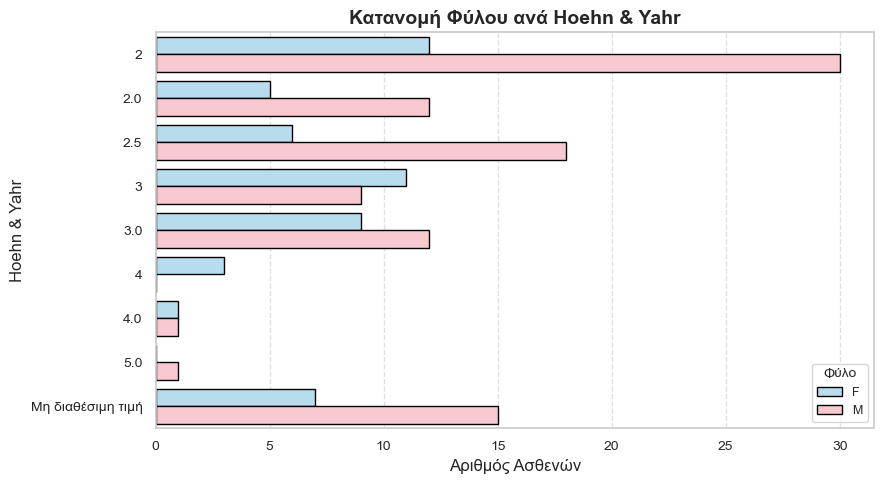


Fluctuations
 Sex            F   M
Fluctuations        
NO            21  43
YES           15  21
Σύνολο        36  64


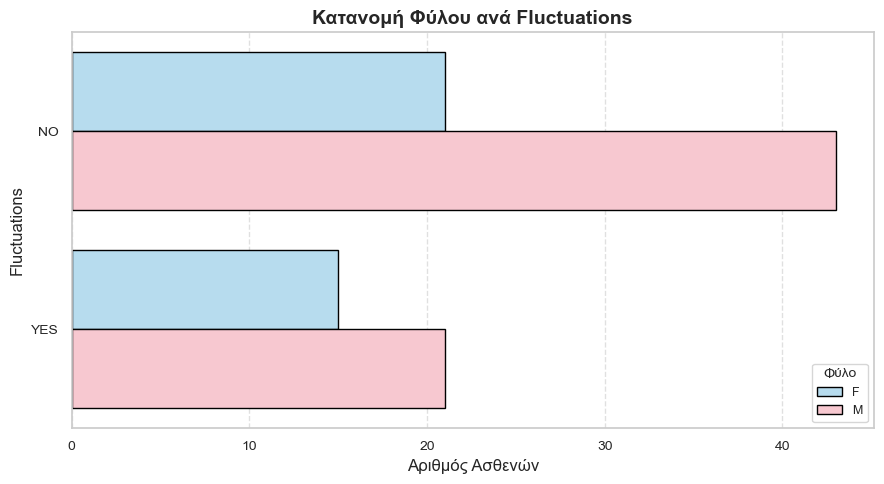


Dyskinesia
 Sex                 F   M
Dyskinesia_bef           
NO                 30  71
YES                21  25
Μη διαθέσιμη τιμή   3   2
Σύνολο             54  98


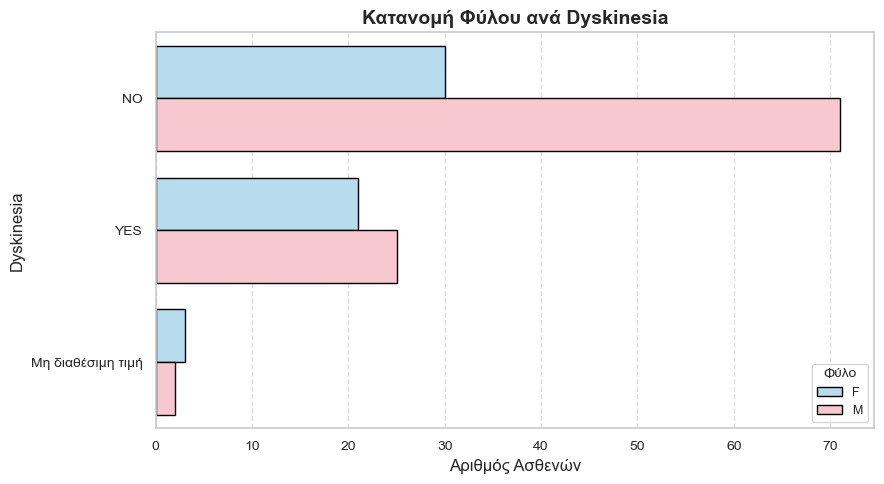


Levodopa Response Quality
 Sex                   F   M
UPDRS_III_dif_class        
Excellent            21  38
Nan                   8  16
Poor                  3  13
Suboptimal           22  31
Σύνολο               54  98


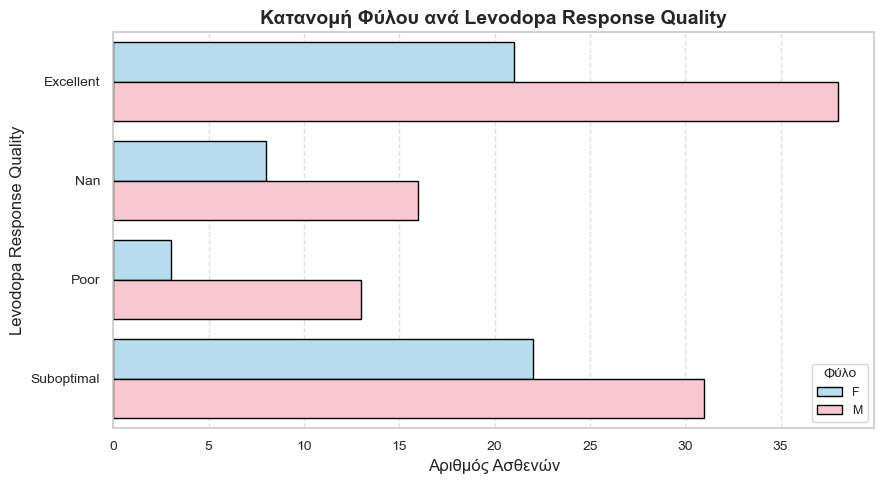


Levodopa Response (%)
 Sex                       F   M
Levodopa_Response_Range        
0-15%                     5  10
15-30%                   19  32
30-50%                   14  27
>50% βελτίωση             7   7
Καμία/Αρνητική            1   6
Μη διαθέσιμη τιμή         8  16
Σύνολο                   54  98


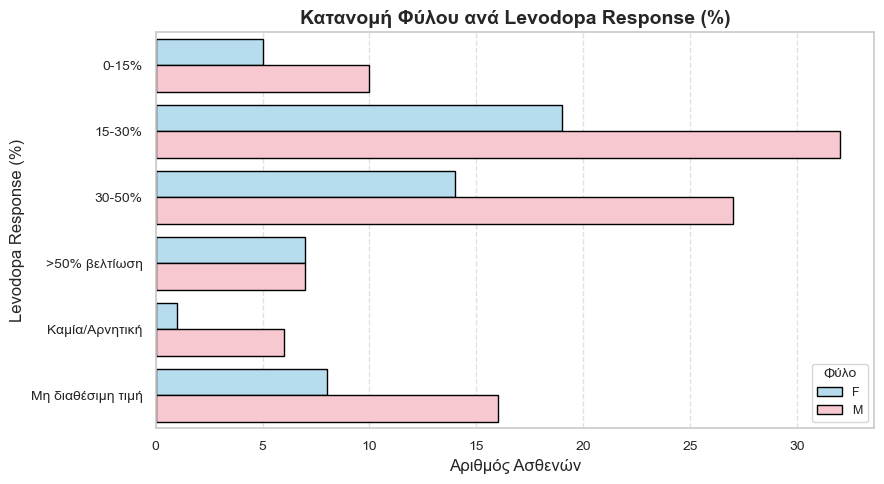

In [19]:
%matplotlib inline
# --- 1. Εισαγωγή Βιβλιοθηκών ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 2. Φόρτωση Δεδομένων ---
# Φόρτωση των δύο αρχείων Excel σε διαφορετικά DataFrames.
df1 = pd.read_excel("CLINICAL_NEW_MINE (1).xlsx")  # Ηράκλειο
df2 = pd.read_excel("Patients_Clinical_Data_face_110624_IB.xlsx")  # Πάτρα

# --- 3. Προετοιμασία και Ενοποίηση ---
# Μετονομασία της στήλης 'Dyskinesia' στο αρχείο της Πάτρας για να ταιριάζει με τη λογική της ανάλυσης.
df2 = df2.rename(columns={'Dyskinesia': 'Dyskinesia_bef'})

# Ενοποίηση όλων των εγγραφών
df_combined = pd.concat([df1, df2], ignore_index=True)

# --- 4. Καθαρισμός και Μετατροπές Δεδομένων ---
df_combined['Sex'] = df_combined['Sex'].astype(str).str.upper()
df_combined['Sex'] = df_combined['Sex'].replace(['NAN', 'NaN', 'nan'], np.nan)
df_combined['Sex'] = df_combined['Sex'].fillna('Μη διαθέσιμο φύλο')


# Παρόμοιος καθαρισμός και για άλλες κατηγορικές στήλες.
df_combined['Dyskinesia_bef'] = df_combined['Dyskinesia_bef'].astype(str).str.upper()
df_combined['Fluctuations'] = df_combined['Fluctuations'].astype(str).str.upper()
df_combined['UPDRS_III_dif_class'] = df_combined['UPDRS_III_dif_class'].astype(str).str.capitalize()
df_combined['UDPRS_III_dif_%'] = df_combined['UDPRS_III_dif_%'].round(2)

# --- 5. Δημιουργία Νέων Κατηγοριών (Feature Engineering) ---
# Ορισμός των ορίων (bins) για την ομαδοποίηση της ποσοστιαίας απόκρισης στη Levodopa.
bins = [-100, -50, -30, -15, 0, 100]
# Ορισμός των ετικετών για κάθε κατηγορία.
labels = ['>50% βελτίωση', '30-50%', '15-30%', '0-15%', 'Καμία/Αρνητική']
# Χρήση της συνάρτησης cut της pandas για τη δημιουργία της νέας κατηγορικής στήλης.
df_combined['Levodopa_Response_Range'] = pd.cut(df_combined['UDPRS_III_dif_%'], bins=bins, labels=labels)

# --- 6. Ορισμός Παραμέτρων Ανάλυσης ---
# Δημιουργία ενός λεξικού (dictionary) που αντιστοιχίζει τα ονόματα των στηλών με "φιλικά" ονόματα για τους τίτλους των γραφημάτων.
categories = {
    'H&Y_bef': 'Hoehn & Yahr',
    'Fluctuations': 'Fluctuations',
    'Dyskinesia_bef': 'Dyskinesia',
    'UPDRS_III_dif_class': 'Levodopa Response Quality',
    'Levodopa_Response_Range': 'Levodopa Response (%)'
}

# --- 7. Δημιουργία Φακέλου Αποθήκευσης ---
# Δημιουργία του φακέλου 'plots' αν δεν υπάρχει ήδη, για να αποθηκευτούν τα γραφήματα.
os.makedirs('plots', exist_ok=True)

# --- 8. Κύριος Βρόχος Ανάλυσης και Οπτικοποίησης ---
# Αρχικοποίηση ενός κενού λεξικού για την αποθήκευση των πινάκων αποτελεσμάτων.
results = {}

# Ορισμός του οπτικού θέματος και της χρωματικής παλέτας για τα γραφήματα.
sns.set_theme(style="whitegrid")
palette = ['#AEDFF7', '#FFC0CB', '#D5F5E3']

for col, name in categories.items():
    if col == 'Fluctuations':
        # Για το Fluctuations κρατάμε μόνο YES και NO
        df_comb = df_combined[df_combined['Fluctuations'].isin(['YES', 'NO'])]
    else:
        # Για τις άλλες στήλες: μετατρέπουμε σε string και κάνουμε αντικατάσταση
        df_combined[col] = df_combined[col].astype(str)
        df_combined[col] = df_combined[col].replace(['MD', 'NAN', 'NaN', 'nan'], np.nan)
        df_combined[col] = df_combined[col].fillna('Μη διαθέσιμη τιμή')
        df_comb = df_combined

    # Ομαδοποίηση των δεδομένων ανά κατηγορία και φύλο, και υπολογισμός του πλήθους.
    # Το unstack() μετατρέπει το φύλο από γραμμές σε στήλες.
    group = df_comb.groupby([col, 'Sex']).size().unstack(fill_value=0)
    group = group[['F', 'M']]  # Κρατάμε μόνο F και M
    group.loc['Σύνολο'] = group.sum(numeric_only=True)
    results[name] = group
    
    # Εκτύπωση του πίνακα 
    print(f"\n{name}\n", group)

    # --- Δημιουργία Γραφήματος ---
    group_plot = group.drop('Σύνολο', errors='ignore').reset_index().melt(id_vars=col, var_name='Sex', value_name='Count')

    plt.figure(figsize=(9,5))
    # Δημιουργία του ραβδογράμματος με τη βιβλιοθήκη seaborn.
    sns.barplot(
        data=group_plot,
        x='Count',
        y=col,
        hue='Sex',
        palette=palette,
        edgecolor='black'
    )
    # Προσθήκη τίτλων και ετικετών στο γράφημα για καλύτερη κατανόηση.
    plt.title(f'Κατανομή Φύλου ανά {name}', fontsize=14, fontweight='bold')
    plt.xlabel('Αριθμός Ασθενών', fontsize=12)
    plt.ylabel(name, fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title='Φύλο', fontsize=9, title_fontsize=10, loc='lower right')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Αποθήκευση Seaborn Plot
    safe_name = name.replace(' ', '_').replace('%', 'pct')
    plt.savefig(f"plots/{safe_name}_seaborn.png", dpi=300, bbox_inches='tight')
    # Εμφάνιση του γραφήματος.
    plt.show()

# --- 9. Εξαγωγή Αποτελεσμάτων σε Excel ---
with pd.ExcelWriter("Κατανομή_Φύλου_Ασθενών_1.xlsx") as writer:
    for name, table in results.items():
        table.to_excel(writer, sheet_name=name[:31])
